# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Lab 6: 09-Oct-2020, Friday
## Neural Networks with Pytorch
In this lab, we explore how to implement neural networks models using Pytorch.

In [1]:
# Import required packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

cf.
> [`torch.nn`](https://pytorch.org/docs/stable/nn.html#) module provides the basic building block for graphs. 

> [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) is a base class for all neural network modules. It can really be any function, but it is often used to implement layers, functions and models. Note that you can also nest modules.

> [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html) module provides some useful functions like convolution operations, activations & loss functions which can be used within a network. Note that, these are not full layers so if you want to specify a layer of any kind you should use `torch.nn.Module`.

> [`torch.optim`](https://pytorch.org/docs/stable/optim.html) is a package implementing various optimization algorithms such as Stochastic Gradient Descent (SGD).

---
### Computation Graphs and Automatic Differentiation

The concept of a **computation graph** is essential to efficient deep
learning programming, because it allows you to not have to write the
back propagation gradients yourself. A computation graph is simply a
specification of how your data is combined to give you the output. Since
the graph totally specifies what parameters were involved with which
operations, it contains enough information to compute derivatives.

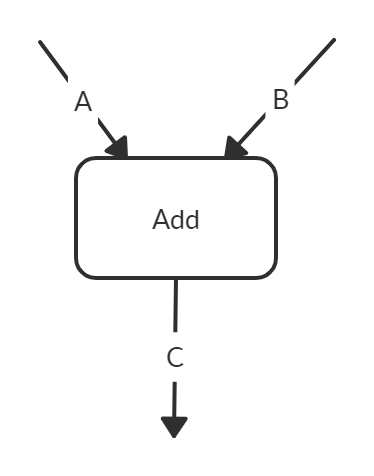

The [`autograd`](https://pytorch.org/docs/stable/autograd.html) package provides **automatic differentiation** for all operations on Tensors. [`torch.Tensor`](https://pytorch.org/docs/stable/generated/torch.tensor.html#torch.tensor) is the central class of the package. This allows you to simply define a model once, in a forward fashion, and the library handles the computation of all gradients in the computational graph.


By default, for arbitrary computations in PyTorch, no gradients are computed.

In [2]:
x = torch.tensor([1., 2., 3])
y = x*x
print(y)

tensor([1., 4., 9.])


In [3]:
print(x.grad, x.grad_fn)
print(x.grad, y.grad_fn)

None None
None None


In [4]:
# requires_grad = True : start to track all operations on it
x = torch.tensor([1., 2., 3],requires_grad=True)
y = x*x
print(y)

tensor([1., 4., 9.], grad_fn=<MulBackward0>)


cf.
> `.grad_fn` attribute references a function that has created a function. Note that for tensors created by the user, these have `None`.


In [5]:
print(x.grad_fn)
print(y.grad_fn)

None


In [6]:
z = y.sum()
print(z)

tensor(14., grad_fn=<SumBackward0>)


In [7]:
print(z.grad_fn)
print(z.grad_fn.next_functions[0][0])
print(z.grad_fn.next_functions[0][0].next_functions[0][0])

In [8]:
print(x.grad)
print(y.grad)
print(z.grad)

None
None
None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  This is separate from the ipykernel package s

At this point, no gradients are computed yet. It is only when we call `.backward()` that PyTorch computes the gradients, and backpropagates them to any node in the graph that *required gradients* (e.g. x).

So now, what is the derivative of this $z$ with respect to the first
component of $x$? In math, we want

\begin{align}\frac{\partial z}{\partial x_0}\end{align}


Well, $z$ knows that it was created as a sum of the tensor $y$. $y$ knows
that it was $x^{2}$. So

\begin{align}z = \overbrace{x_0^2}^\text{$y_0$} + \overbrace{x_1^2}^\text{$y_1$} + \overbrace{x_2^2}^\text{$y_2$}\end{align}

\begin{align}
\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y}\frac{\partial y}{\partial x} = \vec{1}*2x\vert_{x=[1,2,3]} = [2,4,6]
\end{align}

Let's have Pytorch compute the gradient, and see that we were right:

Note if you run this block multiple times, the gradient will increment.
That is because Pytorch *accumulates* the gradient into the `.grad`
property, since for many models this is very convenient.

In [9]:
# Start backpropagation
z.backward()

In [10]:
# Print gradients dz/dx
print(x.grad)

tensor([2., 4., 6.])


In [11]:
# Displaying
for i, name in zip([x, y, z], "xyz"):
    print(f"{name}\ndata: {i.data}\nrequires_grad: {i.requires_grad}\n\
grad: {i.grad}\ngrad_fn: {i.grad_fn}\nis_leaf: {i.is_leaf}\n")

x
data: tensor([1., 2., 3.])
requires_grad: True
grad: tensor([2., 4., 6.])
grad_fn: None
is_leaf: True

y
data: tensor([1., 4., 9.])
requires_grad: True
grad: None
grad_fn: <MulBackward0 object at 0x7fb9d78546d0>
is_leaf: False

z
data: 14.0
requires_grad: True
grad: None
grad_fn: <SumBackward0 object at 0x7fb9d7843f10>
is_leaf: False



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  This is separate from the ipykernel package so we can avoid doing imports until


You can stop `autograd` from tracking history on Tensors with `.requires_grad=True` by wrapping the code block in with `torch.no_grad()`

In [12]:
print(x.requires_grad)
print((x**2).requires_grad)
with torch.no_grad(): # you can use this for evaluating your model
    print((x**2).requires_grad)

True
True
False


By using `.detach()` to get a new Tensor with the same content but that does not require gradients. In other words, we can use it to delete computation history so that we can just take the value.

In [13]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


---
### Logistic Regression using Pytorch
Using [Iris](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) dataset from scikit-learn, we would see the relationship between logistic regression and neural networks.

#### Dataset
Iris data set - a 150 instance, 3-class data set with 4 features.

In [14]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [15]:
print(iris.feature_names)
print(iris.target_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


In [16]:
print(iris.data.shape)
print(iris.target.shape)

(150, 4)
(150,)


In [17]:
iris.data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [18]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Note that our target $y$ is encoded as a single array with classes as its values.

In [19]:
x = torch.from_numpy(iris.data).float()
y = torch.from_numpy(iris.target).long()

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#### Model

##### Logistic regression as a Neural Networks model

$$ x \in R^d : \text{input data of shape } (d,1) $$

\begin{align}w \in R^d : \text{weights for logistic regression, also of shape } (d,1)\end{align}

Logistic regression formula:
\begin{align}\hat y = \sigma(w^Tx+b) = \sigma\big(\sum_{i=1}^{d}w_i \cdot x_i + b\big) \in (0,1), \text{where } \sigma(z) = \frac{1}{1+e^{-z}}\end{align}

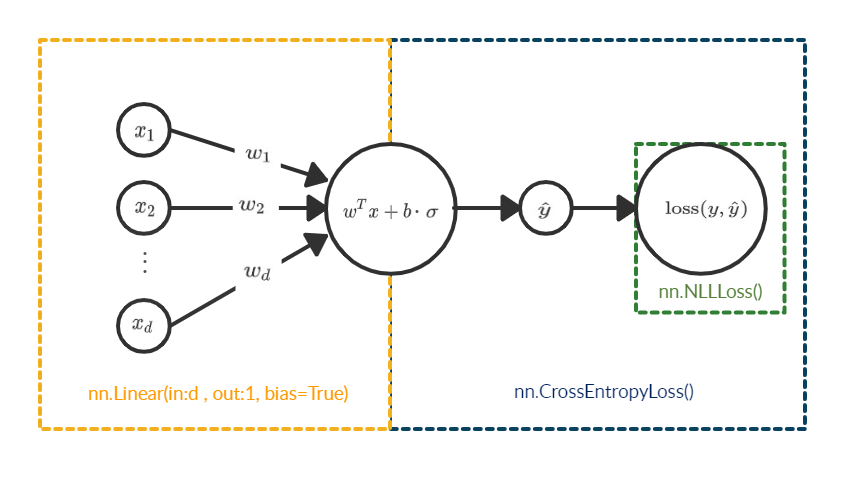

What it means that logistic regression is a basically neural networks model with one linear layer! 

* `nn.Linear` is a simple instance of a module, that just captures a simple linear function.

* Importantly, modules need to have their `forward()` method overridden, and very often you will want to override the `__init__` method as well. 

* The `__init__` method sets up the module, akin to how we set up the `LogisticRegression` model in Part A with some arguments. This is also often where the internal modules and parameters are initialized.

* The `forward` method defines what happens when you *apply* the module.

In the background, PyTorch makes use of your code in the forward method and determines how to implement back-propagation with it - but all you need to do is to define the forward pass since `autograd` will take care of it!



In [21]:
class LogisticRegressionPyTorch(nn.Module):
    def __init__(self, n_in, n_out):
        """
        n_in: Number of features
        n_out: Number of output classes
        """
        # Initialize the parent class - this is a Python requirement
        super().__init__()
        
        # Set up out linear layer. This initializes the weights
        # Note that self.linear is itself a nn.Module, nested within
        #   this module
        self.linear = nn.Linear(n_in, n_out)
        
        # Explicitly initialize the weights with the initialization
        #   scheme we want.
        self.init_weights()
        
    def forward(self, x):
        """
        x: Input data [N, k]
        ---
        Returns: log probabilities of each class [N, c]
        """
        # Apply the linear function to get our logit (real numbers)
        logit = self.linear(x)
        
        # Apply log_softmax to get logs of normalized probabilities
        return F.log_softmax(logit, dim=1)
    
    def init_weights(self):
        # Use some specific initialization schemes
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)

cf. 
> `nn.init.xavier_normal_` fills the input Tensor with values according to the method described in *Understanding the difficulty of training deep feedforward neural networks* - Glorot, X. & Bengio, Y. (2010), using a normal distribution.

> `nn.init.uniform_` fills the input Tensor with values drawn from the uniform distribution $\mathcal{U}(a, b)$.

In [22]:
# Initialize our model. Note we need to provide n_in and n_out
net = LogisticRegressionPyTorch(n_in=x.shape[1], n_out=3)
print(net)

LogisticRegressionPyTorch(
  (linear): Linear(in_features=4, out_features=3, bias=True)
)


In [23]:
# As a quick check, lets investigate the number of parameters in our model:
for param in net.parameters():
    print(param.shape)

torch.Size([3, 4])
torch.Size([3])


In [24]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.6337,  1.0923, -0.3127,  0.2180],
        [ 0.8666,  0.3613, -0.0240, -0.2274],
        [-0.9127,  0.5375,  0.1327, -0.5212]], requires_grad=True)
Parameter containing:
tensor([0.9593, 0.4457, 0.4571], requires_grad=True)


In [25]:
# Set up our criterion - our loss function
criterion = nn.NLLLoss()

# Set up our optimizer. We need to tell the optimizer which
#   parameters it will optimize over (which parameters it is
#   allowed to modify).
optimizer = optim.SGD(net.parameters(), lr=0.1)

cf. 
> `nn.NLLLoss()` is the negative log likelihood loss.
$$L(y)=−log(y)$$
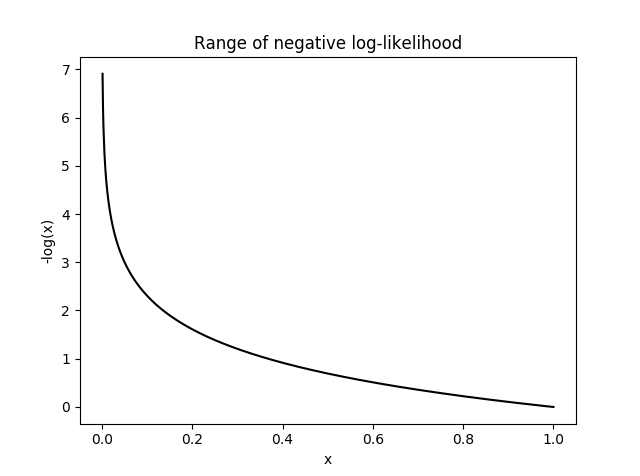

> `nn.optim.SGD` implements Stochastic Gradient Descent.

> `nn.optim.Adam` implements [Adaptive Moment Estimation](https://arxiv.org/abs/1412.6980) algorithm.

In [26]:
#zeroes the gradient buffers of all parameters
net.zero_grad()
print('linear.weight.grad before backward')
print(net.linear.weight.grad)
      
# Compute the predicted log-probabilities
y_hat = net(X_train)

# Compute the loss
loss = criterion(y_hat, y_train)

# Back-propagate the gradients to the parameters
loss.backward()
print('linear.weight.grad after backward')
print(net.linear.weight.grad)

# Apply the gradient updates to the parameters
optimizer.step()

linear.weight.grad before backward
None
linear.weight.grad after backward
tensor([[ 2.3414,  1.0285,  1.9772,  0.6932],
        [-0.1136, -0.0186, -0.0923, -0.0093],
        [-2.2278, -1.0099, -1.8849, -0.6840]])


In [27]:
print(loss)

tensor(4.4212, grad_fn=<NllLossBackward>)


In [28]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

In [29]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.3996,  0.9895, -0.5104,  0.1487],
        [ 0.8780,  0.3632, -0.0147, -0.2265],
        [-0.6899,  0.6385,  0.3212, -0.4528]], requires_grad=True)
Parameter containing:
tensor([0.9224, 0.4486, 0.4911], requires_grad=True)


In [30]:
y_hat.max(dim=1).indices

tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [31]:
loss_val_ls = []
# Run over many iterations!
for i in range(10000):
    
    # Always zero-out the gradients managed by your optimizer
    # PyTorch does not automatically zero-out your gradients
    #   You can also do pt_model.zero_grad() in this case.
    optimizer.zero_grad()
    
    # !! Put model into training mode. This does not do anything
    #   in a simple Logistic Regression model, but will be important 
    #   later. (See: Dropout)
    net.train()
    
    # Compute the predicted log-probabilities
    y_hat = net(X_train)
    
    # Compute the loss
    train_loss = criterion(y_hat, y_train)
    
    # Back-propagate the gradients to the parameters
    train_loss.backward()
    
    # Apply the gradient updates to the parameters
    optimizer.step()
    
    # Recompute the loss in evaluation mode, and record it.
    # Again, this does not do anything here, but will be important later.
    # Since we are evaluating, we will also tell PyTorch not to
    #   compute gradients.
    net.eval()
    with torch.no_grad():
        y_hat = net(X_test)
        eval_loss = criterion(y_hat, y_test)
        
    # Record the loss
    # Note that 'loss' is a Tensor, but loss.item() is a number
    loss_val_ls.append(eval_loss.item())

Text(0, 0.5, 'Log Loss')

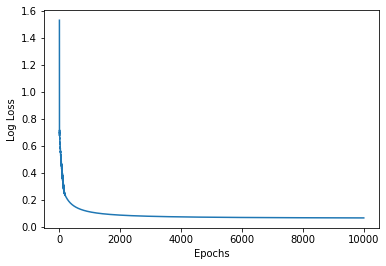

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(loss_val_ls)
plt.xlabel("Epochs")
plt.ylabel("Log Loss")

In [33]:
y_hat.max(dim=1).indices

tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2,
        2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2,
        1, 2])

In [34]:
y_hat.max(dim=1).indices.eq(y_test)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True])

---
## References
- PyTorch Tutorial: Robert Guthrie
- DS-GA 1011 NLP with Representation Learning Fall 2019